Import PlaidML backend in order to use GPU.

In [11]:
import os
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

import keras

Download raw IMDB dataset (ai.stanford.edu/~amaas/data/sentiment) and uncompress it.
Then collect the individual training reviews into a list of strings (one string per review).
Also collect the review labels (pos/neg) into a **labels** list.

In [12]:
imdb_dir = 'C:\\Users\\antra\\OneDrive\\kaggle\\sentiment_analysis\\word_embedding\\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), errors='ignore')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [13]:
texts[0].lower()

"story of a man who has unnatural feelings for a pig. starts out with a opening scene that is a terrific example of absurd comedy. a formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting. even those from the era should be turned off. the cryptic dialogue would make shakespeare seem easy to a third grader. on a technical level it's better than you might think with some good cinematography by future great vilmos zsigmond. future stars sally kirkland and frederic forrest can be seen briefly."

In [14]:
len(set(texts[0].lower().split())) # number of unique words in the first text

91

Tokenizing the data; vectorize the text and prepare a training and validation split. Because pre-trained word embeddings are useful on problems where little training data is available; otherwise; task-specific embeddings would outperform them. Let's restrict the training data to the first 200 samples.

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # cut off reviews after 100 words (this is the size of the vocabulary columns)
training_samples = 200 # trains on 200 samples
validation_samples = 10000 # validates on 10000 samples
max_words = 10000 # considers only the top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words) # creates a tokenizer, takes only the first 10000 common words
tokenizer.fit_on_texts(texts) # build the word index
sequences = tokenizer.texts_to_sequences(texts) # turns strings into lists of integer indices

# could also directly get one-hot binary representations
# one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index # how to recover the word index that was computed
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen) # truncate review after "maxlen", or fill in with 0's if not long enough

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 88584 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


Let's decode one of the reviews to original text.

In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i, '?') for i in data[0]]) # indices offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start ofsequence,” and “unknown.”
decoded_review

"who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a orchestra audience is turned into an insane violent mob by the crazy of it's singers unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting even those from the era should be turned off the dialogue would make shakespeare seem easy to a third on a technical level it's better than you might think with some good cinematography by future great future stars sally and forrest can be seen briefly"

In [21]:
data[0]

array([  34,   44, 7576, 1414,   15,    3, 4252,  514,   43,   16,    3,
        633,  133,   12,    6,    3, 1301,  459,    4, 1751,  209,    3,
       7693,  308,    6,  676,   80,   32, 2137, 1110, 3008,   31,    1,
        929,    4,   42, 5120,  469,    9, 2665, 1751,    1,  223,   55,
         16,   54,  828, 1318,  847,  228,    9,   40,   96,  122, 1484,
         57,  145,   36,    1,  996,  141,   27,  676,  122,    1,  411,
         59,   94, 2278,  303,  772,    5,    3,  837,   20,    3, 1755,
        646,   42,  125,   71,   22,  235,  101,   16,   46,   49,  624,
         31,  702,   84,  702,  378, 3493,    2, 8422,   67,   27,  107,
       3348])

Shuffle data because data is currently ordered as **Negative** reviews first then **Positive** reviews.

In [57]:
indices = np.arange(data.shape[0]) # create indices of words from 0 to number of rows in data
np.random.shuffle(indices) # need to shuffle because data is ordered (neg first, then pos)
data = data[indices] # shuffled data
labels = labels[indices] # shuffled labels

x_train = data[:training_samples] # 200 rows by 100 words
y_train = labels[:training_samples] # 200 labels
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

Download GLOVE word embeddings at https://nlp.stanford.edu/projects/glove then unzip it; parse the unzipped file and build an index that maps words (as strings) to their vector representation (as number vectors).

In [33]:
glove_dir = 'C:\\Users\\antra\\OneDrive\\kaggle\\sentiment_analysis\\word_embedding\\glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), errors='ignore', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Next, build an embedding matrix that can load into Embedding layer. It must be a matrix of shape (max_words, embedding_dim). **Note**: index 0 isn't supposed to stand for any word or token; it's simply a placeholder.

In [37]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # words not found in embedding index will be all 0's.

In [38]:
embedding_matrix.shape

(10000, 100)

Defining the model architecture.

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


The **Embedding** layer has a single weight matrix: a 2D float matrix where each entry is the word vector associated with index i. Let's load the GloVe matrix that we prepared into the Embedding layer, the first layer in the model. We will freeze the Embedding layer (*trainable* to *False*) because pre-trained parts shouldn't be updated during training.

In [40]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

Let's compile and train the model.

In [41]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 32s 159ms/step - loss: 1.5618 - acc: 0.4700 - val_loss: 0.6930 - val_acc: 0.5046
Epoch 2/10
200/200 [==============================] - 27s 133ms/step - loss: 0.6879 - acc: 0.5950 - val_loss: 0.6891 - val_acc: 0.5467
Epoch 3/10
200/200 [==============================] - 27s 133ms/step - loss: 0.5939 - acc: 0.7000 - val_loss: 0.9113 - val_acc: 0.5036
Epoch 4/10
200/200 [==============================] - 26s 132ms/step - loss: 0.5948 - acc: 0.7100 - val_loss: 0.7310 - val_acc: 0.5233
Epoch 5/10
200/200 [==============================] - 26s 132ms/step - loss: 0.5220 - acc: 0.7650 - val_loss: 0.6863 - val_acc: 0.5533
Epoch 6/10
200/200 [==============================] - 26s 131ms/step - loss: 0.2502 - acc: 0.9750 - val_loss: 1.3590 - val_acc: 0.5037
Epoch 7/10
200/200 [==============================] - 26s 132ms/step - loss: 0.4363 - acc: 0.7350 - val_loss: 0.7234 - val_acc: 0.5668
Epoch 8

Now let's plot the model's performance overtime.

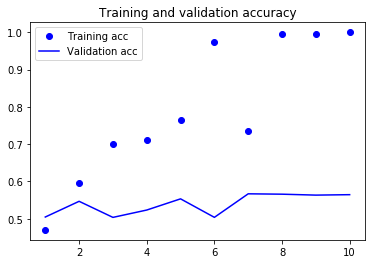

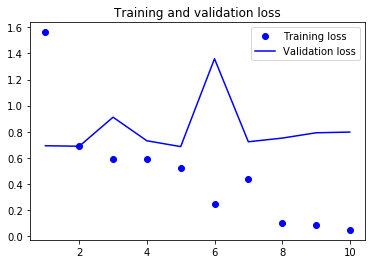

In [46]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, which is understandable since our training set is super small. Recall that we can also train the same model **without loading the pre-trained word embeddings and without freezing the embedding layer**. In that case, we will be learning a **task-specific embedding** of the input tokens; which is generally **more powerful** than pre-trained word embeddings when lots of data is available. Let's try it.

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 31s 156ms/step - loss: 0.7021 - acc: 0.5200 - val_loss: 0.6927 - val_acc: 0.5129
Epoch 2/10
200/200 [==============================] - 26s 132ms/step - loss: 0.4686 - acc: 0.9850 - val_loss: 0.6994 - val_acc: 0.5134
Epoch 3/10
200/200 [==============================] - 27s 133ms/step - loss: 0.2449 - acc: 1.0000 - val_loss: 0.7035 - val_acc: 0.5198
Epoch 4/10
200/200 [==============================] - 26s 131ms/step - loss: 0.1053 - acc: 1.0000 - val_loss: 0.7049 - val_acc: 0.5241
Epoch 5/10
200/200 [==============================] - 27s 133ms/step - loss: 0.0512 - acc: 1.0000 - val_loss: 0.7096 - val_acc: 0.5271
Epoch 6/10
200/200 [==============================] - 26s 132ms/step - loss: 0.0257 - acc: 1.0000 - val_loss: 0.7312 - val_acc: 0.5165
Epoch 7/10
200/200 [==============================] - 26s 131ms/step - loss: 0.0144 - acc: 1.0000 - val_loss: 0.7239 - val_acc: 0.5317
Epoch 8

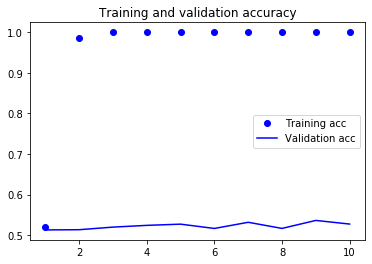

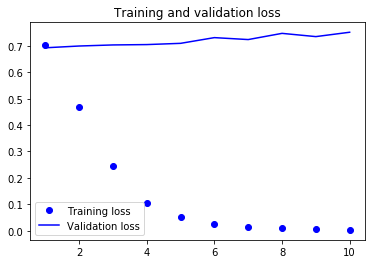

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Compare these plots with the previous plots; we can tell that pre-trained word embeddings outperform learned embeddings. If we increase the number of training samples; this will not be the case anymore. Finally, let's **evaluate** the model on the **test data**. First, we need to **tokenize** the test data like we did with the training data.

In [52]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), errors='ignore')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [53]:
sequence = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Next, let's load and evaluate the first model.

In [54]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test) # [loss, accuracy]

25000/25000 [==============================] - 69s 3ms/step


[0.7868069425201416, 0.57124]